# SoundScapify - Song Recommender based on Soundscape (Part 2 of 4)

This is the second part of the notebooks:  
1. Introduction and Train Dataset EDA
2. **Model Training**
3. Model Prediction with Test Dataset
4. Song Dataset Retrieval

## Import Packages and Dataset

In [1]:
from tensorflow.keras import layers
from tensorflow.keras.layers import TimeDistributed, LayerNormalization, InputLayer
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
import os
from scipy.io import wavfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import kapre
from kapre.composed import get_melspectrogram_layer

from tqdm import tqdm
from glob import glob
import warnings
import pickle

In [2]:
df = pickle.load(open('csv/clean_data.df','rb'))

In [3]:
df.head()

,filename,scene_label,log_melspectrogram
0,audio/bus-lyon-1001-40001-0-a.wav,bus,"[[13.577272, 7.025728, -1.2618985, -3.4342742,..."
1,audio/bus-lyon-1001-40001-1-a.wav,bus,"[[17.600836, 14.177676, 6.091573, 0.81835246, ..."
2,audio/bus-lyon-1001-40001-2-a.wav,bus,"[[18.510744, 16.79232, 11.121583, 1.0732065, -..."
3,audio/bus-lyon-1001-40001-3-a.wav,bus,"[[20.518055, 6.3174534, 4.113715, -3.8069892, ..."
4,audio/bus-lyon-1001-40001-4-a.wav,bus,"[[19.71752, 11.698871, 5.590608, 2.1607356, 0...."


In [4]:
df.shape

(58955, 3)

It has been decided that the cafe labelled audio is going to be removed since the data is imbalanced

In [6]:
# drop rows that is for cafe
df = df[df['scene_label'].str.contains('cafe') != True]
df.reset_index(inplace= True, drop=True)
df

,filename,scene_label,log_melspectrogram
0,audio/bus-lyon-1001-40001-0-a.wav,bus,"[[13.577272, 7.025728, -1.2618985, -3.4342742,..."
1,audio/bus-lyon-1001-40001-1-a.wav,bus,"[[17.600836, 14.177676, 6.091573, 0.81835246, ..."
2,audio/bus-lyon-1001-40001-2-a.wav,bus,"[[18.510744, 16.79232, 11.121583, 1.0732065, -..."
3,audio/bus-lyon-1001-40001-3-a.wav,bus,"[[20.518055, 6.3174534, 4.113715, -3.8069892, ..."
4,audio/bus-lyon-1001-40001-4-a.wav,bus,"[[19.71752, 11.698871, 5.590608, 2.1607356, 0...."
...,...,...,...
57804,clean/NEL-MRT_95.wav,metro,"[[6.318292, 2.3621132, -5.236124, -9.880425, -..."
57805,clean/NEL-MRT_96.wav,metro,"[[10.197929, 9.166535, 3.6991322, 4.068353, -4..."
57806,clean/NEL-MRT_97.wav,metro,"[[11.002901, 10.734147, 0.834878, 0.38001227, ..."
57807,clean/NEL-MRT_98.wav,metro,"[[10.103996, 11.94078, 7.0030684, 3.9187765, 2..."


## Data Generator

For the modelling to have a better learning capability, we decided to build a data generator class which has the same features as Keras Sequence utilities. Keras Sequence is a Base object for fitting to a sequence of data, such as a dataset [[1]](https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence). The data generator will create a sequence of randomised data and fit in into the model within the same epoch.

In [7]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, melspectrograms, labels, n_classes,
                batch_size, shuffle=True):
        self.melspectrograms = melspectrograms
        self.labels = labels
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.shuffle = True
        self.on_epoch_end()
    
    
    def __len__(self):
        return int(np.floor(len(self.melspectrograms) / self.batch_size))
    
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        melspectrogram = [np.asarray(self.melspectrograms[k]) for k in indexes]
        labels = [self.labels[k] for k in indexes]

        t = melspectrogram[0].shape[0]
        dB = melspectrogram[0].shape[1]
        
        # generate a batch of time data
        X = np.empty((self.batch_size, t, dB, 1), dtype=np.float32)
        Y = np.empty((self.batch_size, self.n_classes), dtype=np.float32)
        
        for i, (mel, label) in enumerate(zip(melspectrogram, labels)):
            X[i,] = np.expand_dims(mel, axis=2)
            Y[i,] = to_categorical(label, num_classes=self.n_classes)
        
        return X, Y
    
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.melspectrograms))
        self.indexes = np.array(self.melspectrograms.index.tolist())
        
        if self.shuffle:
            np.random.shuffle(self.indexes)


## Setup Model

For this project, we will be using Long Short-Term Memory (LSTM) Neural Network as our model. As mentioned previously, LSTM Neural Network is a part of Recurrent Neural Network (RNN) which is better in audio pattern recognisation. For the model input, we will be using the Mel-Spectrogram that we obtained earlier. In order to use the LSTM layer, we need to have a TimeDistributed layer which helps to create layer based on time sequence. Meaning, with our 44 time windows, the TimeDistributed layer will process the layer within each time window and later on will be inputted to the LSTM layer. 

In [9]:
def LSTM(N_CLASSES=4):
    i = InputLayer(input_shape=(44,40,1))
    x = LayerNormalization(axis=2, name='batch_norm')(i.output)
    x = TimeDistributed(layers.Reshape((-1,)), name='reshape')(x)
    s = TimeDistributed(layers.Dense(64, activation='tanh'),
                        name='td_dense_tanh')(x)
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=True),
                             name='bidirectional_lstm')(s)
    x = layers.concatenate([s, x], axis=2, name='skip_connection')
    x = layers.Dense(64, activation='relu', name='dense_1_relu')(x)
    x = layers.MaxPooling1D(name='max_pool_1d')(x)
    x = layers.Dense(32, activation='relu', name='dense_2_relu')(x)
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dropout(rate=0.2, name='dropout')(x)
    x = layers.Dense(32, activation='relu',
                         activity_regularizer=l2(0.001),
                         name='dense_3_relu')(x)
    o = layers.Dense(N_CLASSES, activation='softmax', name='softmax')(x)
    model = Model(inputs=i.input, outputs=o, name='long_short_term_memory')
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

Below are the summary of all the layers in the model configured

In [10]:
LSTM().summary()

Model: "long_short_term_memory"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 44, 40, 1)]  0           []                               
                                                                                                  
 batch_norm (LayerNormalization  (None, 44, 40, 1)   80          ['input_1[0][0]']                
 )                                                                                                
                                                                                                  
 reshape (TimeDistributed)      (None, 44, 40)       0           ['batch_norm[0][0]']             
                                                                                                  
 td_dense_tanh (TimeDistributed  (None, 44, 64)      2624        ['reshape[0]

## Training Stage

The training process will be as follows:
1. Set the input and output variable
2. Label encoding the scene label (output variable)
3. Train-test split the dataset
4. Check if the train samples is bigger than the batch size
5. Initiate the DataGenerator class to be inputted
6. Initiate the model that has be configured
7. Create a modelcheckpoint to save the best model and record logger
8. Fit the sample and output into the model

In [8]:
def train(df, batch_size=32, model_type='LSTM'):
    
    params = {'N_CLASSES': len(df['scene_label'].unique())}
    
    csv_path = os.path.join('logs', '{}_history.csv'.format(model_type))

    melspectrograms = df['log_melspectrogram']
  
    classes = df['scene_label'].unique()
    
    le = LabelEncoder()
    le.fit(classes)
    
    labels = df['scene_label']
    labels = pd.Series(le.transform(labels))
    
    wav_train, wav_val, label_train, label_val = train_test_split(melspectrograms,
                                                                  labels,
                                                                  test_size=0.15,
                                                                  random_state=42)
    
    assert len(label_train) >= batch_size, 'Number of train samples must be >= batch_size'
    
    if len(set(label_train)) != params['N_CLASSES']:
        warnings.warn('Found {}/{} classes in training data. Increase data size or change random_state.'.format(len(set(label_train)), params['N_CLASSES']))
    if len(set(label_val)) != params['N_CLASSES']:
        warnings.warn('Found {}/{} classes in validation data. Increase data size or change random_state.'.format(len(set(label_val)), params['N_CLASSES']))

    tg = DataGenerator(wav_train, label_train,
                       params['N_CLASSES'], batch_size=batch_size)
    
    vg = DataGenerator(wav_val, label_val,
                       params['N_CLASSES'], batch_size=batch_size)
    
    model = LSTM(**params)
    
    cp = ModelCheckpoint('models/{}.hdf5'.format(model_type), monitor='val_loss',
                         save_best_only=True, save_weights_only=False,
                         mode='auto', save_freq='epoch', verbose=1)
    csv_logger = CSVLogger(csv_path, append=False)
    
    model.fit(tg, validation_data=vg,
              epochs=30, verbose=1,
              callbacks=[csv_logger, cp])
    
    return model

In [11]:
model = train(df)

Epoch 1/30
1533/1535 [============================>.] - ETA: 0s - loss: 0.8229 - accuracy: 0.6608
Epoch 1: val_loss improved from inf to 0.72945, saving model to models\LSTM.hdf5
1535/1535 [==============================] - 42s 26ms/step - loss: 0.8228 - accuracy: 0.6608 - val_loss: 0.7294 - val_accuracy: 0.7058
Epoch 2/30
1535/1535 [==============================] - ETA: 0s - loss: 0.6217 - accuracy: 0.7566
Epoch 2: val_loss improved from 0.72945 to 0.58143, saving model to models\LSTM.hdf5
1535/1535 [==============================] - 41s 27ms/step - loss: 0.6217 - accuracy: 0.7566 - val_loss: 0.5814 - val_accuracy: 0.7758
Epoch 3/30
1535/1535 [==============================] - ETA: 0s - loss: 0.5275 - accuracy: 0.7950
Epoch 3: val_loss improved from 0.58143 to 0.53243, saving model to models\LSTM.hdf5
1535/1535 [==============================] - 38s 25ms/step - loss: 0.5275 - accuracy: 0.7950 - val_loss: 0.5324 - val_accuracy: 0.7927
Epoch 4/30
1534/1535 [============================

After 30 epochs of iterations, we obtained the accuracy of 0.9542 for the train set and 0.8959 for the validation set which is pretty high. We will remain with the model and check how the model prediction along the epochs

In [14]:
df_result = pd.read_csv('logs/LSTM_history.csv')

In [15]:
df_result.head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.660810,0.822758,0.705835,0.729450
1,1,0.756576,0.621651,0.775830,0.581426
2,2,0.794992,0.527467,0.792666,0.532427
3,3,0.821478,0.467521,0.814114,0.481675
4,4,0.842406,0.417273,0.834871,0.444033
5,5,0.856881,0.381876,0.846402,0.412474
6,6,0.867610,0.357195,0.860355,0.374467
7,7,0.878176,0.332156,0.854128,0.408502
8,8,0.888355,0.305681,0.871310,0.362763
9,9,0.893200,0.293102,0.860009,0.389981


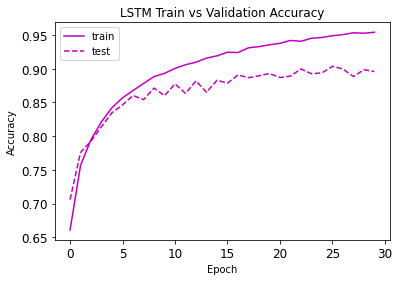

In [16]:
plt.plot(df_result.accuracy, color='m', label='train')
plt.plot(df_result.val_accuracy, ls='--', color='m', label='test')
plt.title('LSTM Train vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.tick_params(axis='both', which='major', labelsize=12)

**Observation :** 
- The first few epochs, we observed that the validation set has a higher accuracy than the train set which we may be considered as under fitting
- After the first few epochs, the train set starts to have a better accuracy than the validation set.
- After 5 epochs, the accuracy of the train and validations starts to widen but remain consistent in the differential
- The train set accuracy remains to be above 0.90 after 10 epochs
- While the validation set accuracy remains to be above 0.85 after 10 epochs
- We can conclude that 30 epochs are sufficient as increasing the epochs will increase the chance of overfitting the model

This is the end of notebook 2. We will try to predict using the model with unseen data that will be covered in the next notebook